# Artificial Scattering S${}_N$



This is a companion notebook for the paper *Ray Effect Mitigation for the Discrete Ordinates Method Using Artificial Scattering* by Martin Frank, Jonas Kusch, Thomas Camminady, and Cory D. Hauck.



The published paper can be found in the journal [Nuclear Science and Engineering](https://www.tandfonline.com/doi/full/10.1080/00295639.2020.1730665) or as a preprint version on [arXiv](https://arxiv.org/abs/1911.08801) (this version differs slightly from the published version as it does not include the modifications that were suggested by the reviewers). If you are unable to access the published version, you can write me an [email](mailto:thomas@camminady.org).

Provided in this notebook is a simple `python` implementation using `numba` to increase the performance. While this is not the exact code that was used to create the results in the paper, it is (hopefully) an almost identical replicate in `python`.
For the line-source testcase, an example result is shown here with artificial scattering turned on.

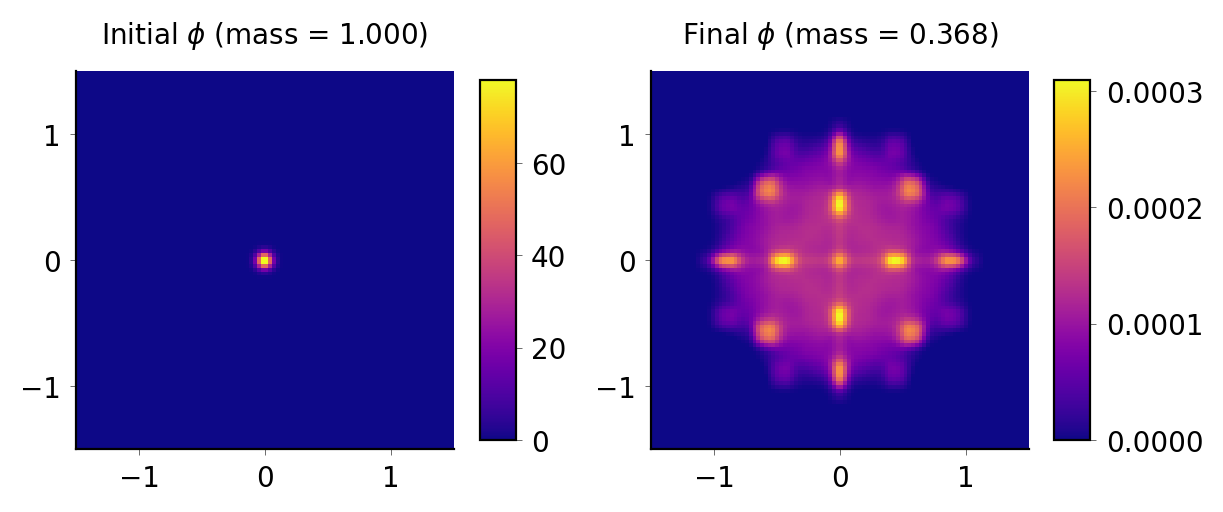

## Load relevant libraries

In [ ]:
import sys, time, numba, math, itertools
import numpy as np

import matplotlib.pyplot as plt

# We need special spherical quadrature that are stored in a different repository
!git clone https://github.com/camminady/PlatonicSolidsQuadratures.git
sys.path.insert(0, "PlatonicSolidsQuadratures")
from platonicsolidsquadrature import platonicsolidsquadrature


## Core components for  second order FVM with slope limiter

In [ ]:
# computes the sclarflux from the angular flux
def scalarflux(psi, qweights):
  return np.einsum("i,ijk->jk", qweights, psi)


@numba.njit(fastmath=True)  # for x to be between low and up
def clamp(x, low, up):
  return low if x < low else (up if x > up else x)


@numba.njit(fastmath=True)  # minmod limiter
def minmod(x, y):
  return clamp(y, x, 0.0) if x < 0 else clamp(y, 0.0, x)


@numba.njit(fastmath=True)  # slopefit for second order scheme
def slope(l, c, r): # left, center, right
  return minmod(2 * (r - c), minmod(2 * (c - l), 0.5 * (r - l)))


@numba.njit(fastmath=True, parallel=True) # second order fvm 
def updateflux(flux, psi, qpoints, dy, dx):
  nq, ny, nx = psi.shape  
  for q in numba.prange(nq):
    qy, qx, qz = qpoints[q, :]
    signy, signx = 0.5 * np.sign(qy), 0.5 * np.sign(qx) 
    offy, offx = int(signy <= 0.0), int(signx <= 0.0)
    for i in range(2, ny - 2):
      for j in range(2, nx - 2):
        s0,s1,s2,s3 = psi[q, i - 2 + offy : i + 2 + offy, j]
        yflux = s2 - s1 + signy * (slope(s1,s2,s3) - slope(s0,s1,s2))
        s0,s1,s2,s3 = psi[q, i, j - 2 + offx : j + 2 + offx]
        xflux =  s2 - s1 + signx * (slope(s1,s2,s3) - slope(s0,s1,s2))       
        flux[q, i, j] = qy / dy * yflux + qx / dx * xflux
                

## Plotting routine

In [ ]:
def plotresult(yedges, xedges, psi0, psi, qweights, style):
  plt.style.use("https://raw.githubusercontent.com/camminady"
  "/kitstyle/master/kitishnotex.mplstyle")
  phi0, phi = scalarflux(psi0,qweights), scalarflux(psi,qweights)
  fig, axs = plt.subplots(1, 2, figsize=(2 * 3, 3))
  for data,ax,title in zip([phi0,phi],axs,["Initial","Final"]):
    mass = np.sum(data)
    if style == "log": data = np.log10(data+1e-16)
    pcm = ax.pcolormesh(yedges, xedges, data[2:-2,2:-2], cmap="plasma")
    cbar = fig.colorbar(pcm, ax=ax, orientation="vertical", shrink=0.6)
    ax.set_title("{} $\phi$ (mass = {:.3f})".format(title, mass))
    ax.set_yticks([yedges[0],yedges[-1]]); ax.set_xticks([xedges[0],xedges[-1]]); 
    ax.set_aspect("equal", "box")
      

## Physical and artificial scattering 

In [ ]:
@numba.njit  # dot product matrix for all quadrature points
def dotmatrix(qpoints):
  dotmatrix = np.zeros((qpoints.shape[0],qpoints.shape[0]))
  for i in range(qpoints.shape[0]):
    for j in range(i):
      d = np.dot(qpoints[i, :], qpoints[j, :])
      dotmatrix[i, j] = dotmatrix[j, i] = d  # symmetry
  return dotmatrix


@numba.njit  # physical scattering kernel
def isotropickernel(mu, params):
  return 1 / (4.0 * np.pi)


@numba.njit  # artificial scattering kernel
def artificialkernel(mu, params):
  factor = 2.0 / np.sqrt(np.pi) / math.erf(2 / params)
  return factor * np.exp(-((1 - mu) ** 2) / params ** 2)


@numba.njit  # scattering matrix
def computescattering(kernel, params, qpoints, qweights):
  dotproduct = dotmatrix(qpoints)  # element wise dot product
  nq, _ = qpoints.shape
  matrix = np.zeros((nq,nq))
  for i in range(nq):
    for j in range(i):
      wij = kernel(dotproduct[i, j], params)
      matrix[i, j] = wij * qweights[j]  # symmetric, except for
      matrix[j, i] = wij * qweights[i]  # the quadrature weight
  for i in range(nq):
    matrix[i, :] /= np.sum(matrix[i, :])  # normalize
  return matrix
    

## Time integration

In [ ]:
@numba.njit(fastmath=True)  # time integration
def euler(psi, qweights, qpoints, dt, flux, sigmaa, sigmas, sigmaas, 
          kernelphysical, kernelartificial, scattering, source):
  nq, ny, nx = psi.shape
    
  # scattering contribution
  for i in range(ny):
    for j in range(nx):
      scattering[:, i, j] = sigmas[i,j] * kernelphysical @ psi[:, i, j]
      scattering[:, i, j] += sigmaas[i,j] * kernelartificial @ psi[:, i, j]

    # transport equation
  sigmat = sigmaa + sigmas + sigmaas
  for q, qw in enumerate(qweights):
    update = -flux[q, :, :] - np.multiply(sigmat, psi[q, :, :]) \
                 + scattering[q, :, :] + source[q, :, :]
    psi[q, :, :] += dt * update 


@numba.njit(fastmath=True)  # execute time loop till end
def run(psi, dt, dx, dy, nt, qpoints, qweights, 
        sigmas, sigmaa, sigmaas, beta, source):
  nq, ny, nx = psi.shape  # with two ghost cells on either side
  flux = np.zeros(psi.shape)
  scattering = np.zeros(psi.shape)

  scatterphysical  = computescattering(isotropickernel, 0.0, qpoints, qweights) 
  scatterartificial = computescattering(artificialkernel, beta / nq, qpoints, qweights)  

  for timestep in range(nt):
    psiOld = np.copy(psi)
    for steps in range(2):
      updateflux(flux, psi, qpoints, dy, dx)
      euler(psi, qweights, qpoints, dt, flux, sigmaa, sigmas, sigmaas, 
            scatterphysical, scatterartificial, scattering, source)
    psi = (psi + psiOld) / 2.0
  return psi


## Driver routine

In [ ]:
def execute(problemparams, numericparams):
  y0, y1, x0, x1, t, fsigmas, fsigmaa, fpsi0, fsource, style = problemparams
  ny, nx, cfl, qpoints, qweights, fsigmaas, beta  = numericparams
  nq = len(qweights)

  yedges, xedges = np.linspace(y0, y1, ny + 1), np.linspace(x0, x1, nx + 1)
  y, x = np.meshgrid((yedges[1:] + yedges[:-1]) / 2, (xedges[1:] + xedges[:-1]) / 2)
  dy, dx = yedges[1] - yedges[0], xedges[1] - xedges[0]


  psi0    = np.zeros((nq, ny + 4, nx + 4 ))   # Ghost cells
  psi     = np.zeros((nq, ny + 4, nx + 4 ))   # Ghost cells
  source  = np.zeros((nq, ny + 4, nx + 4 ))
  sigmaa  = np.zeros((ny + 4, nx + 4 ))
  sigmas  = np.zeros((ny + 4, nx + 4 ))
  sigmaas = np.zeros((ny + 4, nx + 4 ))
  
  for q in range(nq):
    psi0[q,2:-2,2:-2]    = np.vectorize(fpsi0)(y,x)
    psi[q,2:-2,2:-2]     = np.vectorize(fpsi0)(y,x)
    source[q, 2:-2,2:-2] = np.vectorize(fsource)(y,x)
    sigmaa[2:-2,2:-2]    = np.vectorize(fsigmaa)(y,x)
    sigmas[2:-2,2:-2]    = np.vectorize(fsigmas)(y,x)
    sigmaas[2:-2,2:-2]   = np.vectorize(fsigmaas)(y,x)
  mass0 = 1e-200 + np.sum(scalarflux(psi0,qweights))
  psi0 /= mass0
  psi /= mass0
    
  nt = int(np.ceil(t / (cfl / 2 * (dx * dy) / (dx + dy))))
  dt = t / nt
  
  start = time.time()
  psi = run(psi, dt, dx, dy, nt, qpoints, qweights, 
            sigmas, sigmaa, sigmaas, beta, source)
  print("Elapsed time = {} seconds.".format(time.time() - start))
  plotresult(xedges, yedges, psi0, psi,qweights, style)


## Problem setup and execution

In [ ]:
 def linesource():
  sigmas = lambda y,x: 0.0
  sigmaa = lambda y,x: 1.0
  var = 4 * 0.03 ** 2
  psi0 = lambda y,x: np.exp(-(x ** 2 + y ** 2) / var) / var / np.pi
  source = lambda y,x: 0.0
  y0, y1, x0, x1, t = -1.5, 1.5, -1.5, 1.5, 1.0
  plotstyle = "normal"
  return [y0, y1, x0, x1, t, sigmas, sigmaa, psi0, source, plotstyle]

def checkerboard():
  psi0 = lambda y,x: 0.0
  def sigmas(y,x):
    if ((1<=y<=2 or 5<=y<=6) and (1<=x<=2 or 3<=x<=4 or 5<=x<=6)) \
      or ((2<=y<=3 or 4<=y<=5) and (2<=x<=3 or 4<=x<=5 ))  \
      or ((3<=y<=4) and (3<=x<=4 or 5<=x<=6)):
      return 0.0
    else:
      return 1.0

  def sigmaa(y,x):
    if ((1<=y<=2 or 5<=y<=6) and (1<=x<=2 or 3<=x<=4 or 5<=x<=6)) \
      or ((2<=y<=3 or 4<=y<=5) and (2<=x<=3 or 4<=x<=5 ))  \
      or ((3<=y<=4) and (3<=x<=4 or 5<=x<=6)):
      return 10.0
    else:
      return 0.0

  def source(y,x):
    if ((3<=y<=4) and (3<=x<=4)):
      return 1.0
    else:
      return 0.0
  y0, y1, x0, x1, t = 0.0, 7.0, 0.0, 7.0, 3.2
  plotstyle = "log"
  return [y0, y1, x0, x1, t, sigmas, sigmaa, psi0, source,plotstyle]


In [ ]:
ny, nx, cfl, quaddegree = 100, 100, 0.95, 3
qpoints, qweights, _, _, _, _ = platonicsolidsquadrature("ico", quaddegree)
sigmaas = lambda x,y :  1.0
beta = 40
numericparams = [ny, nx, cfl, qpoints, qweights, sigmaas, beta]

execute(linesource(), numericparams)

In [ ]:
ny, nx, cfl, quaddegree = 70, 70, 0.95, 2
qpoints, qweights, _, _, _, _ = platonicsolidsquadrature("ico", quaddegree)
sigmaas = lambda x,y :  0.0
beta = 40
numericparams = [ny, nx, cfl, qpoints, qweights, sigmaas, beta]

execute(checkerboard(), numericparams)